In [25]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from rfgap import RFGAP
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from rfoversample import RFOversampler

import sys
sys.path.append("SupportFunctions")

from prepare_datasets import DatasetPreprocessor  
from imbalancer import ImbalanceHandler

In [26]:
titanic = pd.read_csv('./datasets/titanic.csv')
titanic_cat_cols = ['Pclass', 'Sex', 'Embarked']

COMPARE F1 SCORES

In [27]:
#encode titanic dataset's categorical features, use preprocessor (built off sklearn train-test split) to split the dataset
encoded_titanic = pd.get_dummies(titanic, columns=titanic_cat_cols, dtype=int)
preprocessor = DatasetPreprocessor(encoded_titanic, target_column='Survived')
x_train, y_train, x_test, y_test = (preprocessor.x_train, preprocessor.y_train,
                                    preprocessor.x_test, preprocessor.y_test)

#Introduce a 10:1 imbalance ratio to the training dataset
Imbalancer = ImbalanceHandler(x_train, y_train, imbalance_ratio=0.1) 
x_train_imbal, y_train_imbal = Imbalancer.introduce_imbalance()

#Oversample the imbalanced training dataset using the RFOversampler
TrainData_imbal = pd.concat((y_train_imbal, x_train_imbal), axis=1)
TitanicOversampler = RFOversampler(Data=TrainData_imbal, target_ind=0, encoded=True, cat_cols=titanic_cat_cols)
RF_upsampled_x_train, RF_upsampled_y_train = TitanicOversampler.fit()

Ordinal encoded categorical columns: []

Data Preparation Complete
Train-Test Split: Train (498) | Test (214)
Feature Columns: 12 | Categorical Processed: 0


Applying imbalance ratio: 0.10

Original Class Distribution:
Survived
0    302
1    196

Adjusted Sizes - Minority: 180, Majority: 300

New Class Distribution:
Survived
0    288
1     32


In [28]:
#Upsample imbalanced training dataset using SMOTE
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
SM_upsampled_x_train, SM_upsampled_y_train = smote.fit_resample(x_train_imbal, y_train_imbal)

In [29]:
def Compare_RF_F1scores(n, OG_x_train, OG_y_train, RF_x_train_upsampled, RF_y_train_upsampled, SM_x_train_upsampled, SM_y_train_upsampled, x_test, y_test):

    scores_OG = np.zeros(n)
    scores_RF_upsampled = np.zeros(n)
    scores_SM_upsampled = np.zeros(n)

    for i in range(n):

        #train, fit, and predict original points
        original_RF = RandomForestClassifier(class_weight='balanced')
        original_RF.fit(OG_x_train, OG_y_train)
        y_pred_original = original_RF.predict(x_test)

        #train, fit, and predict points upsampled by Random Forest Upsampler
        RF_upsampled_RF = RandomForestClassifier()
        RF_upsampled_RF.fit(RF_x_train_upsampled, RF_y_train_upsampled)
        y_pred_RF_upsampled = RF_upsampled_RF.predict(x_test)

        #train, fit, and predict points upsampled by SMOTE
        SM_upsampled_RF = RandomForestClassifier()
        SM_upsampled_RF.fit(SM_x_train_upsampled, SM_y_train_upsampled)
        y_pred_SM_upsampled = SM_upsampled_RF.predict(x_test)
    
        #append f1 scores
        scores_OG[i] = f1_score(y_test, y_pred_original, average='binary')
        scores_RF_upsampled[i] = f1_score(y_test, y_pred_RF_upsampled, average='binary')
        scores_SM_upsampled[i] = f1_score(y_test, y_pred_SM_upsampled, average='binary')

    return scores_OG, scores_RF_upsampled, scores_SM_upsampled

    

In [30]:
#F1 scores for the original, RF upsampled, and SMOTE upsampled datasets (from Random Forest Classifier)
scores_OG, scores_RF_upsampled, scores_SM_upsampled = Compare_RF_F1scores(20, x_train_imbal, y_train_imbal,
                                                                          RF_upsampled_x_train, RF_upsampled_y_train,
                                                                          SM_upsampled_x_train, SM_upsampled_y_train,
                                                                          x_test, y_test)

Text(0.5, 0.98, 'F1 Scores From RandomForestClassifier (0.1 imbalance ratio)')

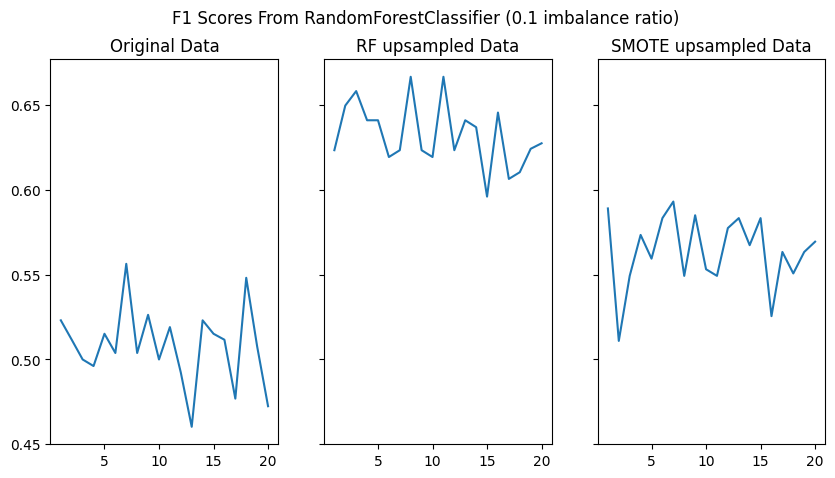

In [31]:
fig, ax = plt.subplots(1,3, figsize=(10,5), sharey=True)

ax[0].plot(range(1,21), scores_OG)
ax[0].set(title='Original Data')
ax[1].plot(range(1,21), scores_RF_upsampled)
ax[1].set(title='RF upsampled Data')
ax[2].plot(range(1,21), scores_SM_upsampled)
ax[2].set(title='SMOTE upsampled Data')
fig.suptitle('F1 Scores From RandomForestClassifier (0.1 imbalance ratio)')

In [35]:
def Compare_LR_F1scores(OG_x_train, OG_y_train, RF_x_train_upsampled, RF_y_train_upsampled, SM_x_train_upsampled, SM_y_train_upsampled, x_test, y_test):

    score_OG = None
    score_RF_upsampled = None
    score_SM_upsampled = None

    #train, fit, and predict original points
    original_LR = LogisticRegression(class_weight='balanced')
    original_LR.fit(OG_x_train, OG_y_train)
    y_pred_original = original_LR.predict(x_test)

    #train, fit, and predict points upsampled by Random Forest Upsampler
    RF_upsampled_LR = LogisticRegression()
    RF_upsampled_LR.fit(RF_x_train_upsampled, RF_y_train_upsampled)
    y_pred_RF_upsampled = RF_upsampled_LR.predict(x_test)

    #train, fit, and predict points upsampled by SMOTE
    SM_upsampled_LR = LogisticRegression()
    SM_upsampled_LR.fit(SM_x_train_upsampled, SM_y_train_upsampled)
    y_pred_SM_upsampled = SM_upsampled_LR.predict(x_test)

    #append f1 scores
    score_OG = f1_score(y_test, y_pred_original, average='binary')
    score_RF_upsampled = f1_score(y_test, y_pred_RF_upsampled, average='binary')
    score_SM_upsampled = f1_score(y_test, y_pred_SM_upsampled, average='binary')

    return score_OG, score_RF_upsampled, score_SM_upsampled

In [ ]:
#F1 scores for the original, RF upsampled, and SMOTE upsampled datasets (from Logistic Regression)
score_OG_LogisticR, score_RF_upsampled_LogisticR, score_SM_upsampled_LogisticR = Compare_LR_F1scores(x_train_imbal, y_train_imbal,
                                                                          RF_upsampled_x_train, RF_upsampled_y_train,
                                                                          SM_upsampled_x_train, SM_upsampled_y_train,
                                                                          x_test, y_test)

Text(0.5, 1.0, 'F1 Scores From Logistic Regression (0.1 imbalance ratio)')

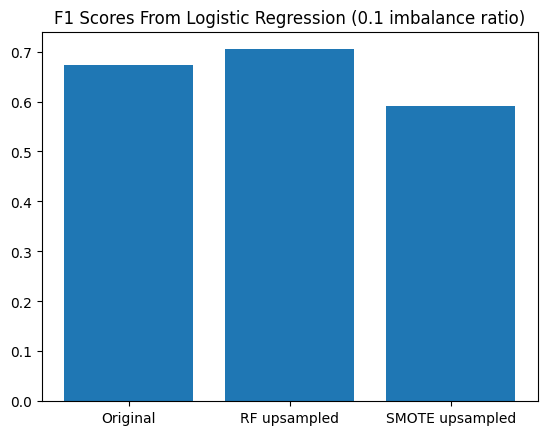

In [40]:
plt.bar(x=['Original', 'RF upsampled', 'SMOTE upsampled'], height=[score_OG_LogisticR, score_RF_upsampled_LogisticR, score_SM_upsampled_LogisticR])
plt.title('F1 Scores From Logistic Regression (0.1 imbalance ratio)')